In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.6 MB/s eta 0:00:00


In [ ]:
import os

print(os.getcwd())

/content


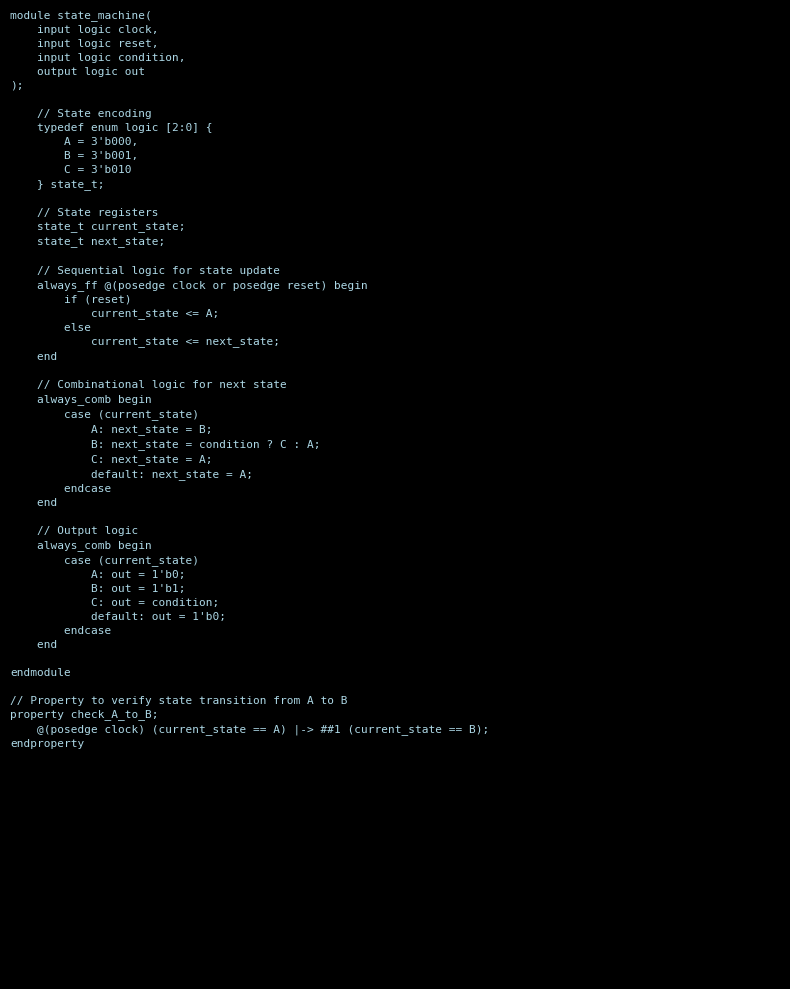

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_code_as_image():
    code = '''module state_machine(
    input logic clock,
    input logic reset,
    input logic condition,
    output logic out
);

    // State encoding
    typedef enum logic [2:0] {
        A = 3'b000,
        B = 3'b001,
        C = 3'b010
    } state_t;

    // State registers
    state_t current_state;
    state_t next_state;

    // Sequential logic for state update
    always_ff @(posedge clock or posedge reset) begin
        if (reset)
            current_state <= A;
        else
            current_state <= next_state;
    end

    // Combinational logic for next state
    always_comb begin
        case (current_state)
            A: next_state = B;
            B: next_state = condition ? C : A;
            C: next_state = A;
            default: next_state = A;
        endcase
    end

    // Output logic
    always_comb begin
        case (current_state)
            A: out = 1'b0;
            B: out = 1'b1;
            C: out = condition;
            default: out = 1'b0;
        endcase
    end

endmodule

// Property to verify state transition from A to B
property check_A_to_B;
    @(posedge clock) (current_state == A) |-> ##1 (current_state == B);
endproperty'''

    # Create figure with black background
    plt.figure(figsize=(8, 10))
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.gcf().set_facecolor('black')

    # Display code with syntax highlighting-like colors
    plt.text(0, 1, code,
             color='lightblue',
             fontfamily='monospace',
             fontsize=8,
             va='top',
             linespacing=1.5)

    # Remove axes
    plt.axis('off')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

display_code_as_image()

In [ ]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaModel
import os
import re
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt

class HDLAttentionPreprocessor:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.tokenizer = RobertaTokenizer.from_pretrained("microsoft/graphcodebert-base")
        self.model = RobertaModel.from_pretrained("microsoft/graphcodebert-base").to(self.device)

    def clean_code(self, code):
        if not isinstance(code, str) or not code.strip():
            return "", []

        lines = code.split('\n')
        cleaned_lines = []
        attention_points = []

        for i, line in enumerate(lines):
            if '//' in line and not line.strip().startswith('//'):
                cleaned_line = line.split('//')[0].strip()
                cleaned_lines.append(cleaned_line)
                attention_points.append(i)
            else:
                cleaned_lines.append(line.strip())

        return '\n'.join(cleaned_lines), attention_points

    def extract_hdl_elements(self, code):
        elements = []
        patterns = {
            'module': r'module\s+\w+\s*\([^;]+\);',
            'always_ff': r'always_ff\s*@\s*\([^)]+\)\s*begin.*?end',
            'always_comb': r'always_comb\s*begin.*?end',
            'typedef': r'typedef\s+enum.*?}\s*\w+;',
            'property': r'property\s+[^;]+;',
            'signal': r'(input|output)\s+logic\s+[^;]+;',
            'register': r'(state_t|logic)\s+\w+\s*;'
        }

        for element_type, pattern in patterns.items():
            matches = re.finditer(pattern, code, re.DOTALL)
            for match in matches:
                elements.append((element_type, match.group()))

        return elements

    def extract_assertion_features(self, assertion):
        """Extract specific features from assertions"""
        temporal_ops = len(re.findall(r'\b(always|eventually|until|next)\b', assertion))
        logical_ops = len(re.findall(r'\b(and|or|not|implies)\b', assertion))
        comparisons = len(re.findall(r'[=!<>]=?', assertion))
        variables = len(set(re.findall(r'\b[a-zA-Z_]\w*\b', assertion)))

        return torch.tensor([
            temporal_ops, logical_ops, comparisons, variables
        ], dtype=torch.float)

    def extract_hdl_features(self, code):
        """Extract HDL-specific features"""
        n_lines = len(code.split('\n'))
        n_tokens = len(code.split())
        always_blocks = len(re.findall(r'always\s*@', code))
        assignments = len(re.findall(r'assign\s+', code))
        registers = len(re.findall(r'reg\s+', code))
        wires = len(re.findall(r'wire\s+', code))
        if_statements = len(re.findall(r'if\s*\(', code))
        case_statements = len(re.findall(r'case\s*\(', code))

        return torch.tensor([
            n_lines, n_tokens, always_blocks, assignments,
            registers, wires, if_statements, case_statements
        ], dtype=torch.float)

    def get_batch_embeddings(self, texts, attention_weights=None):
        if attention_weights is None:
            attention_weights = [1.0] * len(texts)

        inputs = self.tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512,
            add_special_tokens=True
        )

        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        attention_weights = torch.tensor(attention_weights, device=self.device).unsqueeze(-1)

        with torch.no_grad():
            outputs = self.model(**inputs)

        attention_mask = inputs['attention_mask']
        mask_expanded = attention_mask.unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
        sum_embeddings = torch.sum(outputs.last_hidden_state * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        pooled_embeddings = (sum_embeddings / sum_mask) * attention_weights

        return pooled_embeddings.cpu()

    def create_graph_with_attention(self, code, assertion, attention_points):
        elements = self.extract_hdl_elements(code)

        if not elements:
            return None

        # Extract assertion features
        assertion_features = self.extract_assertion_features(assertion)

        # Prepare attention weights with HDL features
        attention_weights = []
        hdl_features = []
        for i, (_, element) in enumerate(elements):
            weight = 2.0 if any(f"L{ap}" in element for ap in attention_points) else 1.0
            attention_weights.append(weight)
            hdl_features.append(self.extract_hdl_features(element))

        # Add weight for assertion
        attention_weights.append(1.0)

        # Get embeddings with attention weights
        all_texts = [elem[1] for elem in elements] + [assertion]
        batch_embeddings = self.get_batch_embeddings(all_texts, attention_weights)

        # Split embeddings and combine with features
        node_features = torch.cat([
            batch_embeddings[:-1],
            torch.stack(hdl_features)
        ], dim=1)

        assertion_embedding = batch_embeddings[-1]

        # Create edges with attention-aware weights
        edge_index = []
        edge_attr = []

        assertion_vars = set(re.findall(r'\b[a-zA-Z_]\w*\b', assertion))
        for i, (_, elem1) in enumerate(elements):
            vars1 = set(re.findall(r'\b[a-zA-Z_]\w*\b', elem1))

            for j, (_, elem2) in enumerate(elements):
                if i != j:
                    vars2 = set(re.findall(r'\b[a-zA-Z_]\w*\b', elem2))
                    shared_vars = vars1 & vars2
                    if shared_vars:
                        edge_index.append([i, j])
                        weight = 2.0 if any(f"L{ap}" in elem1 or f"L{ap}" in elem2
                                          for ap in attention_points) else 1.0
                        edge_attr.append([
                            len(shared_vars),
                            len(shared_vars & assertion_vars),
                            weight
                        ])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() if edge_index else torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.tensor(edge_attr, dtype=torch.float) if edge_attr else torch.zeros((0, 3))

        return Data(
            x=node_features,
            edge_index=edge_index,
            edge_attr=edge_attr,
            assertion_embedding=torch.cat([
                assertion_embedding,
                assertion_features
            ])
        )

if __name__ == "__main__":
    # Read the SystemVerilog file
    with open('test.sv', 'r') as f:
        sv_code = f.read()

    # Create a dummy row to match the previous structure
    test_data = {
        'name': 'check_A_to_B',
        'assertion_sv': 'property check_A_to_B; @(posedge clock) (current_state == A) |-> ##1 (current_state == B); endproperty',
        'code': sv_code,
        'expected_result': 'PASS'
    }

    # Initialize preprocessor
    preprocessor = HDLAttentionPreprocessor()

    # Process the code
    cleaned_code, attention_points = preprocessor.clean_code(test_data['code'])
    graph = preprocessor.create_graph_with_attention(
        cleaned_code,
        test_data['assertion_sv'],
        attention_points
    )

    # Convert to NetworkX graph for visualization
    G = nx.Graph()

    # Add nodes with types
    elements = preprocessor.extract_hdl_elements(cleaned_code)
    node_colors = []
    node_labels = {}

    for i, (element_type, _) in enumerate(elements):
        G.add_node(i)
        if 'always' in element_type:
            color = 'lightblue'
            type_label = 'Always Block'
        elif element_type == 'register':
            color = 'salmon'
            type_label = 'Register'
        elif element_type == 'property':
            color = 'lightgreen'
            type_label = 'Property'
        elif element_type == 'module':
            color = 'yellow'
            type_label = 'Module'
        elif element_type == 'signal':
            color = 'lightpink'
            type_label = 'Signal'
        else:
            color = 'lightgray'
            type_label = element_type.capitalize()

        node_colors.append(color)
        node_labels[i] = f"{i}\n{type_label}"

    # Add edges
    edge_index = graph.edge_index.t().numpy()
    for edge in edge_index:
        G.add_edge(edge[0], edge[1])

    # Visualize
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=1, iterations=50)

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000)
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)
    nx.draw_networkx_labels(G, pos, node_labels, font_size=8)

    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor=c, label=l, markersize=10)
                      for c, l in [('lightblue', 'Always Block'),
                                 ('salmon', 'Register'),
                                 ('lightgreen', 'Property'),
                                 ('yellow', 'Module'),
                                 ('lightpink', 'Signal'),
                                 ('lightgray', 'Other')]]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

    plt.title("HDL Code Graph Structure\nSystemVerilog State Machine", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print("Node types:", {label.split('\n')[1]: node_colors.count(color)
                         for color, label in zip(node_colors, node_labels.values())})

FileNotFoundError: [Errno 2] No such file or directory: 'test.sv'

In [ ]:
!pip install torch_geometric
!pip install transformers


In [ ]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaModel
import os
import re
from torch_geometric.data import Data

class HDLAttentionPreprocessor:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.tokenizer = RobertaTokenizer.from_pretrained("microsoft/graphcodebert-base")
        self.model = RobertaModel.from_pretrained("microsoft/graphcodebert-base").to(self.device)

    def clean_code(self, code):
        if not isinstance(code, str) or not code.strip():
            return "", []

        lines = code.split('\n')
        cleaned_lines = []
        attention_points = []

        for i, line in enumerate(lines):
            if '//' in line and not line.strip().startswith('//'):
                cleaned_line = line.split('//')[0].strip()
                cleaned_lines.append(cleaned_line)
                attention_points.append(i)
            else:
                cleaned_lines.append(line.strip())

        return '\n'.join(cleaned_lines), attention_points

    def extract_hdl_elements(self, code):
        elements = []
        patterns = [
            r'module\s+\w+\s*\([^;]+\);',
            r'(input|output|reg|wire|parameter)\s+[^;]+;',
            r'always\s*@\s*\([^)]+\)\s*begin.*?end',
            r'assign\s+[^;]+;',
            r'initial\s+begin.*?end',
            r'case\s*\([^)]+\).*?endcase',
            r'if\s*\([^)]+\)\s*begin.*?end'
        ]

        for pattern in patterns:
            matches = re.finditer(pattern, code, re.DOTALL)
            elements.extend(match.group() for match in matches)

        return elements

    def extract_assertion_features(self, assertion):
        """Extract specific features from assertions"""
        temporal_ops = len(re.findall(r'\b(always|eventually|until|next)\b', assertion))
        logical_ops = len(re.findall(r'\b(and|or|not|implies)\b', assertion))
        comparisons = len(re.findall(r'[=!<>]=?', assertion))
        variables = len(set(re.findall(r'\b[a-zA-Z_]\w*\b', assertion)))

        return torch.tensor([
            temporal_ops, logical_ops, comparisons, variables
        ], dtype=torch.float)

    def extract_hdl_features(self, code):
        """Extract HDL-specific features"""
        n_lines = len(code.split('\n'))
        n_tokens = len(code.split())
        always_blocks = len(re.findall(r'always\s*@', code))
        assignments = len(re.findall(r'assign\s+', code))
        registers = len(re.findall(r'reg\s+', code))
        wires = len(re.findall(r'wire\s+', code))
        if_statements = len(re.findall(r'if\s*\(', code))
        case_statements = len(re.findall(r'case\s*\(', code))

        return torch.tensor([
            n_lines, n_tokens, always_blocks, assignments,
            registers, wires, if_statements, case_statements
        ], dtype=torch.float)

    def get_batch_embeddings(self, texts, attention_weights=None):
        if attention_weights is None:
            attention_weights = [1.0] * len(texts)

        inputs = self.tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512,
            add_special_tokens=True
        )

        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        attention_weights = torch.tensor(attention_weights, device=self.device).unsqueeze(-1)

        with torch.no_grad():
            outputs = self.model(**inputs)

        attention_mask = inputs['attention_mask']
        mask_expanded = attention_mask.unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
        sum_embeddings = torch.sum(outputs.last_hidden_state * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        pooled_embeddings = (sum_embeddings / sum_mask) * attention_weights

        return pooled_embeddings.cpu()

    def create_graph_with_attention(self, code, assertion, attention_points):
        elements = self.extract_hdl_elements(code)

        if not elements:
            return None

        # Extract assertion features
        assertion_features = self.extract_assertion_features(assertion)

        # Prepare attention weights with HDL features
        attention_weights = []
        hdl_features = []
        for i, element in enumerate(elements):
            weight = 2.0 if any(f"L{ap}" in element for ap in attention_points) else 1.0
            attention_weights.append(weight)
            hdl_features.append(self.extract_hdl_features(element))

        # Add weight for assertion
        attention_weights.append(1.0)

        # Get embeddings with attention weights
        all_texts = elements + [assertion]
        batch_embeddings = self.get_batch_embeddings(all_texts, attention_weights)

        # Split embeddings and combine with features
        node_features = torch.cat([
            batch_embeddings[:-1],
            torch.stack(hdl_features)
        ], dim=1)

        assertion_embedding = batch_embeddings[-1]

        # Create edges with attention-aware weights
        edge_index = []
        edge_attr = []

        assertion_vars = set(re.findall(r'\b[a-zA-Z_]\w*\b', assertion))
        for i, elem1 in enumerate(elements):
            vars1 = set(re.findall(r'\b[a-zA-Z_]\w*\b', elem1))

            for j, elem2 in enumerate(elements):
                if i != j:
                    vars2 = set(re.findall(r'\b[a-zA-Z_]\w*\b', elem2))
                    shared_vars = vars1 & vars2
                    if shared_vars:
                        edge_index.append([i, j])
                        weight = 2.0 if any(f"L{ap}" in elem1 or f"L{ap}" in elem2
                                          for ap in attention_points) else 1.0
                        edge_attr.append([
                            len(shared_vars),
                            len(shared_vars & assertion_vars),
                            weight
                        ])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() if edge_index else torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.tensor(edge_attr, dtype=torch.float) if edge_attr else torch.zeros((0, 3))

        return Data(
            x=node_features,
            edge_index=edge_index,
            edge_attr=edge_attr,
            assertion_embedding=torch.cat([
                assertion_embedding,
                assertion_features
            ])
        )

def preprocess_dataset_with_attention(csv_path):
    df = pd.read_csv(csv_path)
    preprocessor = HDLAttentionPreprocessor()
    graphs = []
    labels = []

    total_rows = len(df)
    for idx, row in df.iterrows():
        try:
            if idx % 10 == 0:
                print(f"Processing row {idx}/{total_rows}")

            cleaned_code, attention_points = preprocessor.clean_code(row['code'])
            graph = preprocessor.create_graph_with_attention(
                cleaned_code,
                row['assertion_sv'],
                attention_points
            )

            if graph is not None:
                label = 1 if row['expected_result'] == 'PASS' else 0
                graphs.append(graph)
                labels.append(label)

        except Exception as e:
            print(f"Error processing row {idx} in {csv_path}: {e}")
            continue

    return graphs, torch.tensor(labels, dtype=torch.long)

if __name__ == "__main__":
    data_dir = "./drive/MyDrive/training_data"
    all_graphs = []
    all_labels = torch.tensor([], dtype=torch.long)

    for file in os.listdir(data_dir):
        if file.endswith(".csv"):
            print(f"Processing {file} with attention mechanism...")
            graphs, labels = preprocess_dataset_with_attention(os.path.join(data_dir, file))
            if graphs:
                all_graphs.extend(graphs)
                all_labels = torch.cat([all_labels, labels])

    if all_graphs:
        torch.save({
            'graphs': all_graphs,
            'labels': all_labels
        }, 'processed_data_enhanced_attention.pt')
        print(f"Processed {len(all_graphs)} graphs successfully")
    else:
        print("No valid graphs were processed")

Processing ALU_assertions_final.csv with attention mechanism...
Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/539 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/59
Processing row 10/59
Processing row 20/59
Processing row 30/59
Processing row 40/59
Processing row 50/59
Processing arbiter_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/50
Processing row 10/50
Processing row 20/50
Processing row 30/50
Processing row 40/50
Processing b01_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/23
Processing row 10/23
Processing row 20/23
Processing b02_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/30
Processing row 10/30
Processing row 20/30
Processing barrel_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/31
Processing row 10/31
Processing row 20/31
Processing row 30/31
Processing BO6_assertions_final.csv with attention mechanism...


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Processing row 0/48
Processing row 10/48
Processing row 20/48
Processing row 30/48
Processing row 40/48
Processing bufai_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/65
Processing row 10/65
Processing row 20/65
Processing row 30/65
Processing row 40/65
Processing row 50/65
Processing row 60/65
Processing crc_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/61
Processing row 10/61
Processing row 20/61
Processing row 30/61
Processing row 40/61
Processing row 50/61
Processing row 60/61
Processing DAIO_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/70
Processing row 10/70
Processing row 20/70
Processing row 30/70
Processing row 40/70
Processing row 50/70
Processing row 60/70
Processing DEKKER_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/30
Processing row 10/30
Processing row 20/30
Processing generated_assertions_bo8.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/29
Processing row 10/29
Processing row 20/29
Processing FOUR_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/30
Processing row 10/30
Processing row 20/30
Processing IBUF_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/20
Processing row 10/20
Processing NULLMODEM_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/44
Processing row 10/44
Processing row 20/44
Processing row 30/44
Processing row 40/44
Processing rbFIFO_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/20
Processing row 10/20
Processing rcu_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/50
Processing row 10/50
Processing row 20/50
Processing row 30/50
Processing row 40/50
Processing REQACK_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/30
Processing row 10/30
Processing row 20/30
Processing rr_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/40
Processing row 10/40
Processing row 20/40
Processing row 30/40
Processing spinner_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/55
Processing row 10/55
Processing row 20/55
Processing row 30/55
Processing row 40/55
Processing row 50/55
Processing srFIFO_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/20
Processing row 10/20
Processing treearb_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/40
Processing row 10/40
Processing row 20/40
Processing row 30/40
Processing ttt_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/50
Processing row 10/50
Processing row 20/50
Processing row 30/50
Processing row 40/50
Processing UNIDEC_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/41
Processing row 10/41
Processing row 20/41
Processing row 30/41
Processing row 40/41
Processing vlunc_assertions_final.csv with attention mechanism...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/47
Processing row 10/47
Processing row 20/47
Processing row 30/47
Processing row 40/47
Processed 983 graphs successfully


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import DataLoader
import numpy as np
from torch.optim.lr_scheduler import OneCycleLR
from torch.nn import TransformerEncoderLayer, TransformerEncoder
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import os
from datetime import datetime

class MetricTracker:
    def __init__(self, save_dir='training_metrics'):
        self.save_dir = save_dir
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        self.metrics = {
            'train': {
                'loss': [], 'accuracy': [], 'precision': [],
                'recall': [], 'f1': [], 'auc': []
            },
            'val': {
                'loss': [], 'accuracy': [], 'precision': [],
                'recall': [], 'f1': [], 'auc': []
            },
            'lr': [],
            'epoch_times': []
        }

    def update(self, phase, epoch_metrics):
        for k, v in epoch_metrics.items():
            if k in self.metrics[phase]:
                self.metrics[phase][k].append(v)

    def plot_metrics(self):
        metrics_to_plot = [
            ('loss', 'Loss'),
            ('accuracy', 'Accuracy'),
            ('f1', 'F1 Score'),
            ('precision', 'Precision'),
            ('recall', 'Recall'),
            ('auc', 'AUC-ROC')
        ]

        for metric, title in metrics_to_plot:
            plt.figure(figsize=(10, 6))
            plt.plot(self.metrics['train'][metric], label=f'Training {title}')
            plt.plot(self.metrics['val'][metric], label=f'Validation {title}')
            plt.title(f'{title} over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel(title)
            plt.legend()
            plt.grid(True)
            plt.savefig(f'{self.save_dir}/{metric}_plot.png')
            plt.close()

        # Save metrics to CSV
        df = pd.DataFrame({
            'epoch': range(len(self.metrics['train']['loss'])),
            'train_loss': self.metrics['train']['loss'],
            'val_loss': self.metrics['val']['loss'],
            'train_acc': self.metrics['train']['accuracy'],
            'val_acc': self.metrics['val']['accuracy'],
            'train_f1': self.metrics['train']['f1'],
            'val_f1': self.metrics['val']['f1'],
            'train_auc': self.metrics['train']['auc'],
            'val_auc': self.metrics['val']['auc'],
            'learning_rate': self.metrics['lr']
        })
        df.to_csv(f'{self.save_dir}/metrics.csv', index=False)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, f"d_model ({d_model}) must be divisible by num_heads ({num_heads})"
        self.mha = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output, _ = self.mha(x, x, x, key_padding_mask=mask)
        return self.norm(x + self.dropout(attn_output))

class HierarchicalAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.adjusted_dim = ((input_dim // num_heads) + 1) * num_heads
        self.input_proj = nn.Linear(input_dim, self.adjusted_dim)
        self.local_attention = MultiHeadAttention(self.adjusted_dim, num_heads, dropout)
        self.global_attention = MultiHeadAttention(hidden_dim, num_heads, dropout)
        self.proj = nn.Linear(self.adjusted_dim, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, mask=None):
        x = self.input_proj(x)
        local_out = self.local_attention(x, mask)
        global_out = self.global_attention(self.proj(local_out), mask)
        return self.norm(global_out)

class EnhancedGAT(nn.Module):
    def __init__(self, nfeat, nhid=512, nclass=2, dropout=0.2, num_heads=12):
        super().__init__()

        self.node_encoder = nn.Sequential(
            nn.Linear(nfeat, nhid),
            nn.LayerNorm(nhid),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(nhid, nhid),
            nn.LayerNorm(nhid)
        )
        self.node_residual = nn.Linear(nfeat, nhid)

        self.edge_encoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 16),
            nn.LayerNorm(16)
        )

        self.assertion_processor = HierarchicalAttention(772, nhid, num_heads=4)

        encoder_layer = TransformerEncoderLayer(
            d_model=nhid,
            nhead=num_heads,
            dim_feedforward=nhid*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = TransformerEncoder(encoder_layer, num_layers=3)

        self.bn1 = nn.BatchNorm1d(nhid)
        self.bn2 = nn.BatchNorm1d(nhid * num_heads)
        self.bn3 = nn.BatchNorm1d(nhid)

        self.gat1 = GATConv(nhid, nhid, heads=num_heads, dropout=dropout, edge_dim=16)
        self.gat2 = GATConv(nhid * num_heads, nhid, heads=num_heads, dropout=dropout, edge_dim=16)
        self.gat3 = GATConv(nhid * num_heads, nhid, heads=1, dropout=dropout, edge_dim=16)

        self.skip1 = nn.Linear(nhid, nhid * num_heads)
        self.skip2 = nn.Linear(nhid * num_heads, nhid)

        self.layer_norm1 = nn.LayerNorm(nhid)
        self.layer_norm2 = nn.LayerNorm(nhid * num_heads)
        self.layer_norm3 = nn.LayerNorm(nhid)

        self.output = nn.Sequential(
            nn.Linear(nhid * 3, nhid * 2),
            nn.LayerNorm(nhid * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(nhid * 2, nhid),
            nn.LayerNorm(nhid),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(nhid, nclass)
        )

        self.dropout = nn.Dropout(dropout)
        self.l2_reg = 0.01

    def forward(self, data):
        node_features = self.node_encoder(data.x)
        node_features = node_features + self.node_residual(data.x)
        node_features = self.layer_norm1(node_features)

        edge_attr = self.edge_encoder(data.edge_attr) if hasattr(data, 'edge_attr') else None

        assertion_emb = data.assertion_embedding.view(-1, 1, 772)
        assertion_features = self.assertion_processor(assertion_emb)
        assertion_features = assertion_features.squeeze(1)

        x1 = self.gat1(node_features, data.edge_index, edge_attr)
        x1 = self.bn2(x1)
        x1 = F.gelu(x1)
        x1 = self.dropout(x1)
        x1 = x1 + self.skip1(node_features)
        x1 = self.layer_norm2(x1)

        x2 = self.gat2(x1, data.edge_index, edge_attr)
        x2 = self.bn2(x2)
        x2 = F.gelu(x2)
        x2 = self.dropout(x2)

        x3 = self.gat3(x2, data.edge_index, edge_attr)
        x3 = self.bn3(x3)
        x3 = x3 + self.skip2(x2)
        x = self.layer_norm3(x3)

        batch_size = data.batch.max().item() + 1
        num_nodes = torch.bincount(data.batch)
        max_nodes = num_nodes.max().item()

        padded_x = torch.zeros(batch_size, max_nodes, x.size(-1), device=x.device)
        mask = torch.zeros(batch_size, max_nodes, dtype=torch.bool, device=x.device)

        start_idx = 0
        for i in range(batch_size):
            nodes_i = num_nodes[i]
            padded_x[i, :nodes_i] = x[start_idx:start_idx + nodes_i]
            mask[i, nodes_i:] = True
            start_idx += nodes_i

        transformer_out = self.transformer(padded_x, src_key_padding_mask=mask)

        mask_expanded = mask.unsqueeze(-1).expand(-1, -1, transformer_out.size(-1))
        transformer_out = transformer_out.masked_fill(mask_expanded, 0.0)
        x = transformer_out.sum(dim=1) / num_nodes.unsqueeze(-1).float()

        combined = torch.cat([
            x,
            assertion_features,
            global_mean_pool(x3, data.batch)
        ], dim=1)

        return self.output(combined)

    def get_l2_reg(self):
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.norm(param)
        return self.l2_reg * l2_loss

def evaluate_metrics(y_true, y_pred, y_prob=None):
    accuracy = (y_true == y_pred).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    cm = confusion_matrix(y_true, y_pred)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
        auc_score = auc(fpr, tpr)
        metrics['auc'] = auc_score
        metrics['fpr'] = fpr
        metrics['tpr'] = tpr

        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob[:, 1])
        metrics['pr_precision'] = precision_curve
        metrics['pr_recall'] = recall_curve

    return metrics

def plot_confusion_matrix(cm, epoch, save_dir='training_metrics'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Epoch {epoch}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{save_dir}/confusion_matrix_epoch_{epoch}.png')
    plt.close()

def save_model_and_metrics(model, metric_tracker, save_dir='model_outputs'):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model_path = f'{save_dir}/model_{timestamp}.pt'
    torch.save({
        'model_state_dict': model.state_dict(),
        'metrics': metric_tracker.metrics,
        'timestamp': timestamp
    }, model_path)

    print(f"\nModel and metrics saved to {model_path}")

def train_model(model, train_loader, val_loader, device, epochs=100):
    metric_tracker = MetricTracker()

    total_steps = epochs * len(train_loader)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=0.02,
        betas=(0.9, 0.999)
    )

    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-4,
        total_steps=total_steps,
        pct_start=0.1,
        div_factor=25,
        final_div_factor=1000,
    )

    criterion = nn.CrossEntropyLoss(
        weight=torch.tensor([1.0, 1.0]).to(device),
        label_smoothing=0.1
    )

    grad_accum_steps = 2
    best_val_f1 = 0

    print("Starting training with:")
    print(f"Total steps: {total_steps}")
    print(f"Batch size: {train_loader.batch_size}")
    print(f"Gradient accumulation steps: {grad_accum_steps}")
    print(f"Effective batch size: {train_loader.batch_size * grad_accum_steps}")

    for epoch in range(epochs):
        epoch_start_time = time.time()

        # Training phase
        model.train()
        total_loss = 0
        train_predictions = []
        train_labels = []
        train_probs = []

        for batch_idx, batch in enumerate(train_loader):
            batch = batch.to(device)

            if not hasattr(batch, 'y') or batch.y is None:
                continue

            try:
                output = model(batch)
                loss = criterion(output, batch.y) + model.get_l2_reg()
                loss = loss / grad_accum_steps
                loss.backward()

                if (batch_idx + 1) % grad_accum_steps == 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    optimizer.zero_grad()
                    scheduler.step()

                total_loss += loss.item() * grad_accum_steps
                pred = output.max(1)[1]

                train_predictions.extend(pred.cpu().numpy())
                train_labels.extend(batch.y.cpu().numpy())
                train_probs.extend(F.softmax(output, dim=1).cpu().detach().numpy())

            except Exception as e:
                print(f"Error in training batch {batch_idx}: {e}")
                continue

        # Calculate training metrics
        train_metrics = evaluate_metrics(
            np.array(train_labels),
            np.array(train_predictions),
            np.array(train_probs)
        )
        train_metrics['loss'] = total_loss/len(train_loader)
        metric_tracker.update('train', train_metrics)

        # Validation phase
        model.eval()
        val_loss = 0
        val_predictions = []
        val_labels = []
        val_probs = []

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)

                if not hasattr(batch, 'y') or batch.y is None:
                    continue

                output = model(batch)
                loss = criterion(output, batch.y)
                val_loss += loss.item()
                pred = output.max(1)[1]

                val_predictions.extend(pred.cpu().numpy())
                val_labels.extend(batch.y.cpu().numpy())
                val_probs.extend(F.softmax(output, dim=1).cpu().detach().numpy())

        # Calculate validation metrics
        val_metrics = evaluate_metrics(
            np.array(val_labels),
            np.array(val_predictions),
            np.array(val_probs)
        )
        val_metrics['loss'] = val_loss/len(val_loader)
        metric_tracker.update('val', val_metrics)

        # Update learning rate tracking
        metric_tracker.metrics['lr'].append(optimizer.param_groups[0]['lr'])

        # Track epoch time
        metric_tracker.metrics['epoch_times'].append(time.time() - epoch_start_time)

        # Print metrics
        print(f'\nEpoch: {epoch:03d}')
        print(f'Training Metrics:')
        print(f'Loss: {train_metrics["loss"]:.4f}')
        print(f'Accuracy: {train_metrics["accuracy"]:.4f}')
        print(f'Precision: {train_metrics["precision"]:.4f}')
        print(f'Recall: {train_metrics["recall"]:.4f}')
        print(f'F1-Score: {train_metrics["f1"]:.4f}')
        print(f'AUC-ROC: {train_metrics["auc"]:.4f}')

        print(f'\nValidation Metrics:')
        print(f'Loss: {val_metrics["loss"]:.4f}')
        print(f'Accuracy: {val_metrics["accuracy"]:.4f}')
        print(f'Precision: {val_metrics["precision"]:.4f}')
        print(f'Recall: {val_metrics["recall"]:.4f}')
        print(f'F1-Score: {val_metrics["f1"]:.4f}')
        print(f'AUC-ROC: {val_metrics["auc"]:.4f}')
        print(f'LR: {optimizer.param_groups[0]["lr"]:.2e}')

        # Plot confusion matrix
        plot_confusion_matrix(val_metrics['confusion_matrix'], epoch)

        # Plot metrics every 10 epochs
        if (epoch + 1) % 10 == 0:
            metric_tracker.plot_metrics()

        # Save best model
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_metrics': val_metrics,
            }, 'best_model.pt')

    # Final plots and save
    metric_tracker.plot_metrics()
    return metric_tracker

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")

    data = torch.load('processed_data_enhanced_attention.pt')
    graphs = data['graphs']
    labels = data['labels']

    sample_graph = graphs[0]
    print("\nFeature dimensions:")
    print(f"Node features: {sample_graph.x.shape}")
    print(f"Assertion embedding: {sample_graph.assertion_embedding.shape}")
    if hasattr(sample_graph, 'edge_attr'):
        print(f"Edge attributes: {sample_graph.edge_attr.shape}")

    print("\nLabel distribution in dataset:")
    print(torch.bincount(labels))

    nfeat = sample_graph.x.shape[1]

    train_size = int(0.8 * len(graphs))
    indices = torch.randperm(len(graphs))

    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_dataset = [graphs[i] for i in train_indices]
    val_dataset = [graphs[i] for i in val_indices]

    for i, graph in enumerate(train_dataset):
        graph.y = labels[train_indices[i]]
    for i, graph in enumerate(val_dataset):
        graph.y = labels[val_indices[i]]

    print("\nDataset sizes:")
    print(f"Training: {len(train_dataset)}")
    print(f"Validation: {len(val_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    print("\nInitializing enhanced model...")
    model = EnhancedGAT(
        nfeat=nfeat,
        nhid=768,
        nclass=2,
        dropout=0.2,
        num_heads=12
    ).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Train model and get metric tracker
    metric_tracker = train_model(model, train_loader, val_loader, device)

    # Save final model and metrics
    save_model_and_metrics(model, metric_tracker)

    # Print final best metrics
    best_val_f1 = max(metric_tracker.metrics['val']['f1'])
    best_val_acc = max(metric_tracker.metrics['val']['accuracy'])
    print(f"\nBest validation F1-Score: {best_val_f1:.4f}")
    print(f"Best validation Accuracy: {best_val_acc:.4f}")

if __name__ == "__main__":
    main()

Using device: cuda
GPU: Tesla T4

Feature dimensions:
Node features: torch.Size([15, 776])
Assertion embedding: torch.Size([772])
Edge attributes: torch.Size([118, 3])

Label distribution in dataset:


<ipython-input-15-3a76a50f78ef>:452: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('processed_data_enhanced_attention.pt')


tensor([416, 567])

Dataset sizes:
Training: 786
Validation: 197

Initializing enhanced model...


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Total parameters: 147,437,834
Trainable parameters: 147,437,834
Starting training with:
Total steps: 5000
Batch size: 16
Gradient accumulation steps: 2
Effective batch size: 32


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(



Epoch: 000
Training Metrics:
Loss: 15.8362
Accuracy: 0.5916
Precision: 0.6158
Recall: 0.7622
F1-Score: 0.6812
AUC-ROC: 0.5488

Validation Metrics:
Loss: 0.6760
Accuracy: 0.5939
Precision: 0.5939
Recall: 1.0000
F1-Score: 0.7452
AUC-ROC: 0.5262
LR: 4.59e-06

Epoch: 001
Training Metrics:
Loss: 15.7977
Accuracy: 0.6018
Precision: 0.6401
Recall: 0.6956
F1-Score: 0.6667
AUC-ROC: 0.6340

Validation Metrics:
Loss: 0.6837
Accuracy: 0.5939
Precision: 0.5939
Recall: 1.0000
F1-Score: 0.7452
AUC-ROC: 0.5909
LR: 6.36e-06

Epoch: 002
Training Metrics:
Loss: 15.8049
Accuracy: 0.5687
Precision: 0.6022
Recall: 0.7267
F1-Score: 0.6586
AUC-ROC: 0.6038

Validation Metrics:
Loss: 0.6781
Accuracy: 0.5939
Precision: 0.5939
Recall: 1.0000
F1-Score: 0.7452
AUC-ROC: 0.5748
LR: 9.25e-06

Epoch: 003
Training Metrics:
Loss: 15.7936
Accuracy: 0.6018
Precision: 0.6384
Recall: 0.7022
F1-Score: 0.6688
AUC-ROC: 0.6326

Validation Metrics:
Loss: 0.6756
Accuracy: 0.5939
Precision: 0.5939
Recall: 1.0000
F1-Score: 0.7452
A

In [ ]:
####TESTING WITH ATTNETION#####

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import DataLoader, Data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import numpy as np
import pandas as pd
from transformers import RobertaTokenizer, RobertaModel
import os
import re
from torch.nn import TransformerEncoderLayer, TransformerEncoder

# First include the model class
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.mha = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output, _ = self.mha(x, x, x, key_padding_mask=mask)
        return self.norm(x + self.dropout(attn_output))

class HierarchicalAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.adjusted_dim = ((input_dim // num_heads) + 1) * num_heads
        self.input_proj = nn.Linear(input_dim, self.adjusted_dim)
        self.local_attention = MultiHeadAttention(self.adjusted_dim, num_heads, dropout)
        self.global_attention = MultiHeadAttention(hidden_dim, num_heads, dropout)
        self.proj = nn.Linear(self.adjusted_dim, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, mask=None):
        x = self.input_proj(x)
        local_out = self.local_attention(x, mask)
        global_out = self.global_attention(self.proj(local_out), mask)
        return self.norm(global_out)

class EnhancedGAT(nn.Module):
    def __init__(self, nfeat, nhid=512, nclass=2, dropout=0.2, num_heads=12):
        super().__init__()
        self.node_encoder = nn.Sequential(
            nn.Linear(nfeat, nhid),
            nn.LayerNorm(nhid),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(nhid, nhid),
            nn.LayerNorm(nhid)
        )
        self.node_residual = nn.Linear(nfeat, nhid)
        self.edge_encoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 16),
            nn.LayerNorm(16)
        )
        self.assertion_processor = HierarchicalAttention(772, nhid, num_heads=4)
        encoder_layer = TransformerEncoderLayer(d_model=nhid, nhead=num_heads,
                                              dim_feedforward=nhid*4, dropout=dropout,
                                              batch_first=True)
        self.transformer = TransformerEncoder(encoder_layer, num_layers=3)
        self.bn1 = nn.BatchNorm1d(nhid)
        self.bn2 = nn.BatchNorm1d(nhid * num_heads)
        self.bn3 = nn.BatchNorm1d(nhid)
        self.gat1 = GATConv(nhid, nhid, heads=num_heads, dropout=dropout, edge_dim=16)
        self.gat2 = GATConv(nhid * num_heads, nhid, heads=num_heads, dropout=dropout, edge_dim=16)
        self.gat3 = GATConv(nhid * num_heads, nhid, heads=1, dropout=dropout, edge_dim=16)
        self.skip1 = nn.Linear(nhid, nhid * num_heads)
        self.skip2 = nn.Linear(nhid * num_heads, nhid)
        self.layer_norm1 = nn.LayerNorm(nhid)
        self.layer_norm2 = nn.LayerNorm(nhid * num_heads)
        self.layer_norm3 = nn.LayerNorm(nhid)
        self.output = nn.Sequential(
            nn.Linear(nhid * 3, nhid * 2),
            nn.LayerNorm(nhid * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(nhid * 2, nhid),
            nn.LayerNorm(nhid),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(nhid, nclass)
        )
        self.dropout = nn.Dropout(dropout)
        self.l2_reg = 0.01

    def forward(self, data):
        node_features = self.node_encoder(data.x)
        node_features = node_features + self.node_residual(data.x)
        node_features = self.layer_norm1(node_features)

        edge_attr = self.edge_encoder(data.edge_attr) if hasattr(data, 'edge_attr') else None

        assertion_emb = data.assertion_embedding.view(-1, 1, 772)
        assertion_features = self.assertion_processor(assertion_emb)
        assertion_features = assertion_features.squeeze(1)

        x1 = self.gat1(node_features, data.edge_index, edge_attr)
        x1 = self.bn2(x1)
        x1 = F.gelu(x1)
        x1 = self.dropout(x1)
        x1 = x1 + self.skip1(node_features)
        x1 = self.layer_norm2(x1)

        x2 = self.gat2(x1, data.edge_index, edge_attr)
        x2 = self.bn2(x2)
        x2 = F.gelu(x2)
        x2 = self.dropout(x2)

        x3 = self.gat3(x2, data.edge_index, edge_attr)
        x3 = self.bn3(x3)
        x3 = x3 + self.skip2(x2)
        x = self.layer_norm3(x3)

        batch_size = data.batch.max().item() + 1
        num_nodes = torch.bincount(data.batch)
        max_nodes = num_nodes.max().item()

        padded_x = torch.zeros(batch_size, max_nodes, x.size(-1), device=x.device)
        mask = torch.zeros(batch_size, max_nodes, dtype=torch.bool, device=x.device)

        start_idx = 0
        for i in range(batch_size):
            nodes_i = num_nodes[i]
            padded_x[i, :nodes_i] = x[start_idx:start_idx + nodes_i]
            mask[i, nodes_i:] = True
            start_idx += nodes_i

        transformer_out = self.transformer(padded_x, src_key_padding_mask=mask)

        mask_expanded = mask.unsqueeze(-1).expand(-1, -1, transformer_out.size(-1))
        transformer_out = transformer_out.masked_fill(mask_expanded, 0.0)
        x = transformer_out.sum(dim=1) / num_nodes.unsqueeze(-1).float()

        combined = torch.cat([
            x,
            assertion_features,
            global_mean_pool(x3, data.batch)
        ], dim=1)

        return self.output(combined)

    def get_l2_reg(self):
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.norm(param)
        return self.l2_reg * l2_loss

# Include the preprocessor class
class HDLAttentionPreprocessor:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.tokenizer = RobertaTokenizer.from_pretrained("microsoft/graphcodebert-base")
        self.model = RobertaModel.from_pretrained("microsoft/graphcodebert-base").to(self.device)

    def clean_code(self, code):
        if not isinstance(code, str) or not code.strip():
            return "", []
        lines = code.split('\n')
        cleaned_lines = []
        attention_points = []
        for i, line in enumerate(lines):
            if '//' in line and not line.strip().startswith('//'):
                cleaned_line = line.split('//')[0].strip()
                cleaned_lines.append(cleaned_line)
                attention_points.append(i)
            else:
                cleaned_lines.append(line.strip())
        return '\n'.join(cleaned_lines), attention_points

    def extract_hdl_elements(self, code):
        elements = []
        patterns = [
            r'module\s+\w+\s*\([^;]+\);',
            r'(input|output|reg|wire|parameter)\s+[^;]+;',
            r'always\s*@\s*\([^)]+\)\s*begin.*?end',
            r'assign\s+[^;]+;',
            r'initial\s+begin.*?end',
            r'case\s*\([^)]+\).*?endcase',
            r'if\s*\([^)]+\)\s*begin.*?end'
        ]
        for pattern in patterns:
            matches = re.finditer(pattern, code, re.DOTALL)
            elements.extend(match.group() for match in matches)
        return elements

    def extract_assertion_features(self, assertion):
        temporal_ops = len(re.findall(r'\b(always|eventually|until|next)\b', assertion))
        logical_ops = len(re.findall(r'\b(and|or|not|implies)\b', assertion))
        comparisons = len(re.findall(r'[=!<>]=?', assertion))
        variables = len(set(re.findall(r'\b[a-zA-Z_]\w*\b', assertion)))
        return torch.tensor([temporal_ops, logical_ops, comparisons, variables], dtype=torch.float)

    def extract_hdl_features(self, code):
        n_lines = len(code.split('\n'))
        n_tokens = len(code.split())
        always_blocks = len(re.findall(r'always\s*@', code))
        assignments = len(re.findall(r'assign\s+', code))
        registers = len(re.findall(r'reg\s+', code))
        wires = len(re.findall(r'wire\s+', code))
        if_statements = len(re.findall(r'if\s*\(', code))
        case_statements = len(re.findall(r'case\s*\(', code))
        return torch.tensor([n_lines, n_tokens, always_blocks, assignments,
                           registers, wires, if_statements, case_statements], dtype=torch.float)

    def get_batch_embeddings(self, texts, attention_weights=None):
        if attention_weights is None:
            attention_weights = [1.0] * len(texts)
        inputs = self.tokenizer(texts, return_tensors="pt", padding=True,
                              truncation=True, max_length=512, add_special_tokens=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        attention_weights = torch.tensor(attention_weights, device=self.device).unsqueeze(-1)
        with torch.no_grad():
            outputs = self.model(**inputs)
        attention_mask = inputs['attention_mask']
        mask_expanded = attention_mask.unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
        sum_embeddings = torch.sum(outputs.last_hidden_state * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        pooled_embeddings = (sum_embeddings / sum_mask) * attention_weights
        return pooled_embeddings.cpu()

    def create_graph_with_attention(self, code, assertion, attention_points):
        elements = self.extract_hdl_elements(code)
        if not elements:
            return None
        assertion_features = self.extract_assertion_features(assertion)
        attention_weights = []
        hdl_features = []
        for i, element in enumerate(elements):
            weight = 2.0 if any(f"L{ap}" in element for ap in attention_points) else 1.0
            attention_weights.append(weight)
            hdl_features.append(self.extract_hdl_features(element))
        attention_weights.append(1.0)
        all_texts = elements + [assertion]
        batch_embeddings = self.get_batch_embeddings(all_texts, attention_weights)
        node_features = torch.cat([batch_embeddings[:-1], torch.stack(hdl_features)], dim=1)
        assertion_embedding = batch_embeddings[-1]
        edge_index = []
        edge_attr = []
        assertion_vars = set(re.findall(r'\b[a-zA-Z_]\w*\b', assertion))
        for i, elem1 in enumerate(elements):
            vars1 = set(re.findall(r'\b[a-zA-Z_]\w*\b', elem1))
            for j, elem2 in enumerate(elements):
                if i != j:
                    vars2 = set(re.findall(r'\b[a-zA-Z_]\w*\b', elem2))
                    shared_vars = vars1 & vars2
                    if shared_vars:
                        edge_index.append([i, j])
                        weight = 2.0 if any(f"L{ap}" in elem1 or f"L{ap}" in elem2
                                          for ap in attention_points) else 1.0
                        edge_attr.append([len(shared_vars), len(shared_vars & assertion_vars), weight])
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() if edge_index else torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.tensor(edge_attr, dtype=torch.float) if edge_attr else torch.zeros((0, 3))
        return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr,
                   assertion_embedding=torch.cat([assertion_embedding, assertion_features]))

def preprocess_dataset_with_attention(csv_path):
    df = pd.read_csv(csv_path)
    preprocessor = HDLAttentionPreprocessor()
    graphs = []
    labels = []
    total_rows = len(df)
    for idx, row in df.iterrows():
        try:
            if idx % 10 == 0:
                print(f"Processing row {idx}/{total_rows}")
            cleaned_code, attention_points = preprocessor.clean_code(row['code'])
            graph = preprocessor.create_graph_with_attention(cleaned_code, row['assertion_sv'], attention_points)
            if graph is not None:
                label = 1 if row['expected_result'] == 'PASS' else 0
                graphs.append(graph)
                labels.append(label)
        except Exception as e:
            print(f"Error processing row {idx} in {csv_path}: {e}")
            continue
    return graphs, torch.tensor(labels, dtype=torch.long)

# Testing function
def test_saved_model(test_data_path='./drive/MyDrive/test_data_attention.csv', model_path='best_model.pt'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print("Processing test data...")
    test_graphs, test_labels = preprocess_dataset_with_attention(test_data_path)

    if not test_graphs:
        print("No valid graphs were processed from test data!")
        return None

    print(f"Processed {len(test_graphs)} test samples")

    test_loader = DataLoader(test_graphs, batch_size=16)

    model = EnhancedGAT(
        nfeat=test_graphs[0].x.shape[1],
        nhid=768,
        nclass=2,
        dropout=0.2,
        num_heads=12
    ).to(device)

    print("Loading model weights...")
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print("Running predictions...")
    test_predictions = []
    test_probs = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            pred = output.max(1)[1]
            probs = F.softmax(output, dim=1)

            test_predictions.extend(pred.cpu().numpy())
            test_probs.extend(probs.cpu().numpy())

    test_predictions = np.array(test_predictions)
    test_probs = np.array(test_probs)

    accuracy = (test_labels.numpy() == test_predictions).mean()
    cm = confusion_matrix(test_labels, test_predictions)
    fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(test_labels, test_probs[:, 1])
    pr_auc = auc(recall, precision)

    print("\nTest Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Test Set Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('test_confusion_matrix.png')
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('test_roc_curve.png')
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.savefig('test_pr_curve.png')
    plt.close()

    results_df = pd.DataFrame({
        'True_Label': test_labels.numpy(),
        'Predicted_Label': test_predictions,
        'Probability_Class_0': test_probs[:, 0],
        'Probability_Class_1': test_probs[:, 1]
    })
    results_df.to_csv('test_results.csv', index=False)

    return {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm,
        'predictions': test_predictions,
        'probabilities': test_probs
    }

if __name__ == "__main__":
    results = test_saved_model()
    if results:
        print("\nTesting completed! Check the generated plots and test_results.csv for detailed results.")
    else:
        print("\nTesting failed! Check the error messages above.")

Using device: cuda
Processing test data...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/20
Processing row 10/20
Processed 20 test samples


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Loading model weights...


<ipython-input-31-060473d5aea4>:314: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Running predictions...

Test Results:
Accuracy: 0.9500
ROC AUC: 0.9500
PR AUC: 0.9655

Testing completed! Check the generated plots and test_results.csv for detailed results.


In [ ]:
##TESTING W NO ATTENTION DATA###

from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import DataLoader, Data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import numpy as np
import pandas as pd
from transformers import RobertaTokenizer, RobertaModel
import os
import re
from torch.nn import TransformerEncoderLayer, TransformerEncoder

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.mha = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output, _ = self.mha(x, x, x, key_padding_mask=mask)
        return self.norm(x + self.dropout(attn_output))

class HierarchicalAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.adjusted_dim = ((input_dim // num_heads) + 1) * num_heads
        self.input_proj = nn.Linear(input_dim, self.adjusted_dim)
        self.local_attention = MultiHeadAttention(self.adjusted_dim, num_heads, dropout)
        self.global_attention = MultiHeadAttention(hidden_dim, num_heads, dropout)
        self.proj = nn.Linear(self.adjusted_dim, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, mask=None):
        x = self.input_proj(x)
        local_out = self.local_attention(x, mask)
        global_out = self.global_attention(self.proj(local_out), mask)
        return self.norm(global_out)

class EnhancedGAT(nn.Module):
    def __init__(self, nfeat, nhid=512, nclass=2, dropout=0.2, num_heads=12):
        super().__init__()
        self.node_encoder = nn.Sequential(
            nn.Linear(nfeat, nhid),
            nn.LayerNorm(nhid),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(nhid, nhid),
            nn.LayerNorm(nhid)
        )
        self.node_residual = nn.Linear(nfeat, nhid)
        self.edge_encoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 16),
            nn.LayerNorm(16)
        )
        self.assertion_processor = HierarchicalAttention(772, nhid, num_heads=4)
        encoder_layer = TransformerEncoderLayer(d_model=nhid, nhead=num_heads,
                                              dim_feedforward=nhid*4, dropout=dropout,
                                              batch_first=True)
        self.transformer = TransformerEncoder(encoder_layer, num_layers=3)
        self.bn1 = nn.BatchNorm1d(nhid)
        self.bn2 = nn.BatchNorm1d(nhid * num_heads)
        self.bn3 = nn.BatchNorm1d(nhid)
        self.gat1 = GATConv(nhid, nhid, heads=num_heads, dropout=dropout, edge_dim=16)
        self.gat2 = GATConv(nhid * num_heads, nhid, heads=num_heads, dropout=dropout, edge_dim=16)
        self.gat3 = GATConv(nhid * num_heads, nhid, heads=1, dropout=dropout, edge_dim=16)
        self.skip1 = nn.Linear(nhid, nhid * num_heads)
        self.skip2 = nn.Linear(nhid * num_heads, nhid)
        self.layer_norm1 = nn.LayerNorm(nhid)
        self.layer_norm2 = nn.LayerNorm(nhid * num_heads)
        self.layer_norm3 = nn.LayerNorm(nhid)
        self.output = nn.Sequential(
            nn.Linear(nhid * 3, nhid * 2),
            nn.LayerNorm(nhid * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(nhid * 2, nhid),
            nn.LayerNorm(nhid),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(nhid, nclass)
        )
        self.dropout = nn.Dropout(dropout)
        self.l2_reg = 0.01

    def forward(self, data):
        node_features = self.node_encoder(data.x)
        node_features = node_features + self.node_residual(data.x)
        node_features = self.layer_norm1(node_features)

        edge_attr = self.edge_encoder(data.edge_attr) if hasattr(data, 'edge_attr') else None

        assertion_emb = data.assertion_embedding.view(-1, 1, 772)
        assertion_features = self.assertion_processor(assertion_emb)
        assertion_features = assertion_features.squeeze(1)

        x1 = self.gat1(node_features, data.edge_index, edge_attr)
        x1 = self.bn2(x1)
        x1 = F.gelu(x1)
        x1 = self.dropout(x1)
        x1 = x1 + self.skip1(node_features)
        x1 = self.layer_norm2(x1)

        x2 = self.gat2(x1, data.edge_index, edge_attr)
        x2 = self.bn2(x2)
        x2 = F.gelu(x2)
        x2 = self.dropout(x2)

        x3 = self.gat3(x2, data.edge_index, edge_attr)
        x3 = self.bn3(x3)
        x3 = x3 + self.skip2(x2)
        x = self.layer_norm3(x3)

        batch_size = data.batch.max().item() + 1
        num_nodes = torch.bincount(data.batch)
        max_nodes = num_nodes.max().item()

        padded_x = torch.zeros(batch_size, max_nodes, x.size(-1), device=x.device)
        mask = torch.zeros(batch_size, max_nodes, dtype=torch.bool, device=x.device)

        start_idx = 0
        for i in range(batch_size):
            nodes_i = num_nodes[i]
            padded_x[i, :nodes_i] = x[start_idx:start_idx + nodes_i]
            mask[i, nodes_i:] = True
            start_idx += nodes_i

        transformer_out = self.transformer(padded_x, src_key_padding_mask=mask)
        mask_expanded = mask.unsqueeze(-1).expand(-1, -1, transformer_out.size(-1))
        transformer_out = transformer_out.masked_fill(mask_expanded, 0.0)
        x = transformer_out.sum(dim=1) / num_nodes.unsqueeze(-1).float()

        combined = torch.cat([
            x,
            assertion_features,
            global_mean_pool(x3, data.batch)
        ], dim=1)

        return self.output(combined)

class HDLPreprocessor:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.tokenizer = RobertaTokenizer.from_pretrained("microsoft/graphcodebert-base")
        self.model = RobertaModel.from_pretrained("microsoft/graphcodebert-base").to(self.device)

    def clean_code(self, code):
        if not isinstance(code, str) or not code.strip():
            return ""
        lines = code.split('\n')
        cleaned_lines = []
        for line in lines:
            if '//' in line:
                cleaned_line = line.split('//')[0].strip()
                cleaned_lines.append(cleaned_line)
            else:
                cleaned_lines.append(line.strip())
        return '\n'.join(cleaned_lines)

    def extract_hdl_elements(self, code):
        elements = []
        patterns = [
            r'module\s+\w+\s*\([^;]+\);',
            r'(input|output|reg|wire|parameter)\s+[^;]+;',
            r'always\s*@\s*\([^)]+\)\s*begin.*?end',
            r'assign\s+[^;]+;',
            r'initial\s+begin.*?end',
            r'case\s*\([^)]+\).*?endcase',
            r'if\s*\([^)]+\)\s*begin.*?end'
        ]
        for pattern in patterns:
            matches = re.finditer(pattern, code, re.DOTALL)
            elements.extend(match.group() for match in matches)
        return elements

    def extract_assertion_features(self, assertion):
        temporal_ops = len(re.findall(r'\b(always|eventually|until|next)\b', assertion))
        logical_ops = len(re.findall(r'\b(and|or|not|implies)\b', assertion))
        comparisons = len(re.findall(r'[=!<>]=?', assertion))
        variables = len(set(re.findall(r'\b[a-zA-Z_]\w*\b', assertion)))
        return torch.tensor([temporal_ops, logical_ops, comparisons, variables], dtype=torch.float)

    def extract_hdl_features(self, code):
        n_lines = len(code.split('\n'))
        n_tokens = len(code.split())
        always_blocks = len(re.findall(r'always\s*@', code))
        assignments = len(re.findall(r'assign\s+', code))
        registers = len(re.findall(r'reg\s+', code))
        wires = len(re.findall(r'wire\s+', code))
        if_statements = len(re.findall(r'if\s*\(', code))
        case_statements = len(re.findall(r'case\s*\(', code))
        return torch.tensor([n_lines, n_tokens, always_blocks, assignments,
                           registers, wires, if_statements, case_statements], dtype=torch.float)

    def get_batch_embeddings(self, texts):
        inputs = self.tokenizer(texts, return_tensors="pt", padding=True,
                              truncation=True, max_length=512, add_special_tokens=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.model(**inputs)
        attention_mask = inputs['attention_mask']
        mask_expanded = attention_mask.unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
        sum_embeddings = torch.sum(outputs.last_hidden_state * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        return (sum_embeddings / sum_mask).cpu()

    def create_graph(self, code, assertion):
        elements = self.extract_hdl_elements(code)
        if not elements:
            return None
        assertion_features = self.extract_assertion_features(assertion)
        hdl_features = []
        for element in elements:
            hdl_features.append(self.extract_hdl_features(element))

        all_texts = elements + [assertion]
        batch_embeddings = self.get_batch_embeddings(all_texts)
        node_features = torch.cat([batch_embeddings[:-1], torch.stack(hdl_features)], dim=1)
        assertion_embedding = batch_embeddings[-1]

        edge_index = []
        edge_attr = []
        assertion_vars = set(re.findall(r'\b[a-zA-Z_]\w*\b', assertion))
        for i, elem1 in enumerate(elements):
            vars1 = set(re.findall(r'\b[a-zA-Z_]\w*\b', elem1))
            for j, elem2 in enumerate(elements):
                if i != j:
                    vars2 = set(re.findall(r'\b[a-zA-Z_]\w*\b', elem2))
                    shared_vars = vars1 & vars2
                    if shared_vars:
                        edge_index.append([i, j])
                        edge_attr.append([len(shared_vars), len(shared_vars & assertion_vars), 1.0])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() if edge_index else torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.tensor(edge_attr, dtype=torch.float) if edge_attr else torch.zeros((0, 3))

        return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr,
                   assertion_embedding=torch.cat([assertion_embedding, assertion_features]))

def preprocess_dataset(csv_path):
    df = pd.read_csv(csv_path)
    preprocessor = HDLPreprocessor()
    graphs = []
    labels = []

    total_rows = len(df)
    for idx, row in df.iterrows():
        try:
            if idx % 10 == 0:
                print(f"Processing row {idx}/{total_rows}")

            cleaned_code = preprocessor.clean_code(row['code'])
            graph = preprocessor.create_graph(cleaned_code, row['assertion_sv'])

            if graph is not None:
                label = 1 if row['expected_result'] == 'PASS' else 0
                graphs.append(graph)
                labels.append(label)

        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            continue

    return graphs, torch.tensor(labels, dtype=torch.long)

def test_model(test_data_path='test_data.csv', model_path='best_model.pt'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print("Processing test data...")
    test_graphs, test_labels = preprocess_dataset(test_data_path)

    if not test_graphs:
        print("No valid graphs were processed from test data!")
        return None

    print(f"Processed {len(test_graphs)} test samples")
    test_loader = DataLoader(test_graphs, batch_size=16)

    model = EnhancedGAT(
        nfeat=test_graphs[0].x.shape[1],
        nhid=768,
        nclass=2,
        dropout=0.2,
        num_heads=12
    ).to(device)

    print("Loading model weights...")
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print("Running predictions...")
    test_predictions = []
    test_probs = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            pred = output.max(1)[1]
            probs = F.softmax(output, dim=1)
            test_predictions.extend(pred.cpu().numpy())
            test_probs.extend(probs.cpu().numpy())

    test_predictions = np.array(test_predictions)
    test_probs = np.array(test_probs)

    accuracy = (test_labels.numpy() == test_predictions).mean()
    cm = confusion_matrix(test_labels, test_predictions)
    fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(test_labels, test_probs[:, 1])
    pr_auc = auc(recall, precision)

    print("\nTest Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Test Set Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('test_confusion_matrix.png')
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig('test_roc_curve.png')
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.savefig('test_pr_curve.png')
    plt.close()

    results_df = pd.DataFrame({
        'True_Label': test_labels.numpy(),
        'Predicted_Label': test_predictions,
        'Probability_Class_0': test_probs[:, 0],
        'Probability_Class_1': test_probs[:, 1]
    })
    results_df.to_csv('test_results.csv', index=False)

    return {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm,
        'predictions': test_predictions,
        'probabilities': test_probs
    }

if __name__ == "__main__":
    print("Starting testing process...")
    results = test_model(
        test_data_path='/content/drive/MyDrive/test2_data.csv',
        model_path='/content/best_model.pt'  # Updated to correct path
    )

    if results:
        print("\nTesting completed successfully!")
        print("Generated files:")
        print("- test_confusion_matrix.png")
        print("- test_roc_curve.png")
        print("- test_pr_curve.png")
        print("- test_results.csv")
    else:
        print("\nTesting failed! Check the error messages above.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting testing process...
Using device: cuda
Processing test data...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing row 0/10
Processed 10 test samples


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Loading model weights...


<ipython-input-34-0e146414dc76>:303: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Running predictions...

Test Results:
Accuracy: 0.5000
ROC AUC: 0.3750
PR AUC: 0.6172

Testing completed successfully!
Generated files:
- test_confusion_matrix.png
- test_roc_curve.png
- test_pr_curve.png
- test_results.csv


In [ ]:
pwd

'/content'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import DataLoader
import numpy as np
from torch.optim.lr_scheduler import OneCycleLR
from torch.nn import TransformerEncoderLayer, TransformerEncoder
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import os
from datetime import datetime

class MetricTracker:
    def __init__(self, num_folds, save_dir='training_metrics'):
        self.save_dir = save_dir
        self.num_folds = num_folds
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        self.fold_metrics = {f'fold_{i}': {
            'train': {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []},
            'val': {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
        } for i in range(num_folds)}

        self.avg_metrics = {
            'train': {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []},
            'val': {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
        }

    def update(self, phase, epoch_metrics, fold):
        for k, v in epoch_metrics.items():
            if k in self.fold_metrics[f'fold_{fold}'][phase]:
                self.fold_metrics[f'fold_{fold}'][phase][k].append(v)

    def compute_average_metrics(self):
        for phase in ['train', 'val']:
            for metric in self.avg_metrics[phase].keys():
                for epoch in range(len(self.fold_metrics['fold_0'][phase][metric])):
                    values = [self.fold_metrics[f'fold_{i}'][phase][metric][epoch]
                            for i in range(self.num_folds)]
                    self.avg_metrics[phase][metric].append(np.mean(values))

    def plot_metrics(self):
        self.compute_average_metrics()
        metrics_to_plot = [
            ('loss', 'Loss'),
            ('accuracy', 'Accuracy'),
            ('f1', 'F1 Score'),
            ('precision', 'Precision'),
            ('recall', 'Recall'),
            ('auc', 'AUC-ROC')
        ]

        for metric, title in metrics_to_plot:
            plt.figure(figsize=(10, 6))
            plt.plot(self.avg_metrics['train'][metric], label=f'Training {title}')
            plt.plot(self.avg_metrics['val'][metric], label=f'Validation {title}')
            plt.title(f'{title} over Epochs (Averaged across {self.num_folds} folds)')
            plt.xlabel('Epoch')
            plt.ylabel(title)
            plt.legend()
            plt.grid(True)
            plt.savefig(f'{self.save_dir}/{metric}_plot.png')
            plt.close()

        df = pd.DataFrame({
            'epoch': range(len(self.avg_metrics['train']['loss'])),
            'train_loss': self.avg_metrics['train']['loss'],
            'val_loss': self.avg_metrics['val']['loss'],
            'train_acc': self.avg_metrics['train']['accuracy'],
            'val_acc': self.avg_metrics['val']['accuracy'],
            'train_f1': self.avg_metrics['train']['f1'],
            'val_f1': self.avg_metrics['val']['f1'],
            'train_auc': self.avg_metrics['train']['auc'],
            'val_auc': self.avg_metrics['val']['auc']
        })
        df.to_csv(f'{self.save_dir}/metrics.csv', index=False)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, f"d_model ({d_model}) must be divisible by num_heads ({num_heads})"
        self.mha = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output, _ = self.mha(x, x, x, key_padding_mask=mask)
        return self.norm(x + self.dropout(attn_output))

class HierarchicalAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.adjusted_dim = ((input_dim // num_heads) + 1) * num_heads
        self.input_proj = nn.Linear(input_dim, self.adjusted_dim)
        self.local_attention = MultiHeadAttention(self.adjusted_dim, num_heads, dropout)
        self.global_attention = MultiHeadAttention(hidden_dim, num_heads, dropout)
        self.proj = nn.Linear(self.adjusted_dim, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, mask=None):
        x = self.input_proj(x)
        local_out = self.local_attention(x, mask)
        global_out = self.global_attention(self.proj(local_out), mask)
        return self.norm(global_out)

class EnhancedGAT(nn.Module):
    def __init__(self, nfeat, nhid=512, nclass=2, dropout=0.2, num_heads=12):
        super().__init__()
        self.node_encoder = nn.Sequential(
            nn.Linear(nfeat, nhid),
            nn.LayerNorm(nhid),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(nhid, nhid),
            nn.LayerNorm(nhid)
        )
        self.node_residual = nn.Linear(nfeat, nhid)
        self.edge_encoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 16),
            nn.LayerNorm(16)
        )
        self.assertion_processor = HierarchicalAttention(772, nhid, num_heads=4)
        encoder_layer = TransformerEncoderLayer(
            d_model=nhid,
            nhead=num_heads,
            dim_feedforward=nhid*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = TransformerEncoder(encoder_layer, num_layers=3)
        self.bn1 = nn.BatchNorm1d(nhid)
        self.bn2 = nn.BatchNorm1d(nhid * num_heads)
        self.bn3 = nn.BatchNorm1d(nhid)
        self.gat1 = GATConv(nhid, nhid, heads=num_heads, dropout=dropout, edge_dim=16)
        self.gat2 = GATConv(nhid * num_heads, nhid, heads=num_heads, dropout=dropout, edge_dim=16)
        self.gat3 = GATConv(nhid * num_heads, nhid, heads=1, dropout=dropout, edge_dim=16)
        self.skip1 = nn.Linear(nhid, nhid * num_heads)
        self.skip2 = nn.Linear(nhid * num_heads, nhid)
        self.layer_norm1 = nn.LayerNorm(nhid)
        self.layer_norm2 = nn.LayerNorm(nhid * num_heads)
        self.layer_norm3 = nn.LayerNorm(nhid)
        self.output = nn.Sequential(
            nn.Linear(nhid * 3, nhid * 2),
            nn.LayerNorm(nhid * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(nhid * 2, nhid),
            nn.LayerNorm(nhid),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(nhid, nclass)
        )
        self.dropout = nn.Dropout(dropout)
        self.l2_reg = 0.01

    def forward(self, data):
        node_features = self.node_encoder(data.x)
        node_features = node_features + self.node_residual(data.x)
        node_features = self.layer_norm1(node_features)

        edge_attr = self.edge_encoder(data.edge_attr) if hasattr(data, 'edge_attr') else None

        assertion_emb = data.assertion_embedding.view(-1, 1, 772)
        assertion_features = self.assertion_processor(assertion_emb)
        assertion_features = assertion_features.squeeze(1)

        x1 = self.gat1(node_features, data.edge_index, edge_attr)
        x1 = self.bn2(x1)
        x1 = F.gelu(x1)
        x1 = self.dropout(x1)
        x1 = x1 + self.skip1(node_features)
        x1 = self.layer_norm2(x1)

        x2 = self.gat2(x1, data.edge_index, edge_attr)
        x2 = self.bn2(x2)
        x2 = F.gelu(x2)
        x2 = self.dropout(x2)

        x3 = self.gat3(x2, data.edge_index, edge_attr)
        x3 = self.bn3(x3)
        x3 = x3 + self.skip2(x2)
        x = self.layer_norm3(x3)

        batch_size = data.batch.max().item() + 1
        num_nodes = torch.bincount(data.batch)
        max_nodes = num_nodes.max().item()

        padded_x = torch.zeros(batch_size, max_nodes, x.size(-1), device=x.device)
        mask = torch.zeros(batch_size, max_nodes, dtype=torch.bool, device=x.device)

        start_idx = 0
        for i in range(batch_size):
            nodes_i = num_nodes[i]
            padded_x[i, :nodes_i] = x[start_idx:start_idx + nodes_i]
            mask[i, nodes_i:] = True
            start_idx += nodes_i

        transformer_out = self.transformer(padded_x, src_key_padding_mask=mask)
        mask_expanded = mask.unsqueeze(-1).expand(-1, -1, transformer_out.size(-1))
        transformer_out = transformer_out.masked_fill(mask_expanded, 0.0)
        x = transformer_out.sum(dim=1) / num_nodes.unsqueeze(-1).float()

        combined = torch.cat([
            x,
            assertion_features,
            global_mean_pool(x3, data.batch)
        ], dim=1)

        return self.output(combined)

    def get_l2_reg(self):
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.norm(param)
        return self.l2_reg * l2_loss

def evaluate_metrics(y_true, y_pred, y_prob=None):
    accuracy = (y_true == y_pred).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    cm = confusion_matrix(y_true, y_pred)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
        auc_score = auc(fpr, tpr)
        metrics['auc'] = auc_score
        metrics['fpr'] = fpr
        metrics['tpr'] = tpr

        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob[:, 1])
        metrics['pr_precision'] = precision_curve
        metrics['pr_recall'] = recall_curve

    return metrics

def plot_confusion_matrix(cm, epoch, fold, save_dir='training_metrics'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Fold {fold}, Epoch {epoch}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{save_dir}/confusion_matrix_fold_{fold}_epoch_{epoch}.png')
    plt.close()

def train_fold(model, train_loader, val_loader, device, fold, epochs=50):
    total_steps = epochs * len(train_loader)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=0.02,
        betas=(0.9, 0.999)
    )

    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-4,
        total_steps=total_steps,
        pct_start=0.1,
        div_factor=25,
        final_div_factor=1000,
    )

    criterion = nn.CrossEntropyLoss(
        weight=torch.tensor([1.0, 1.0]).to(device),
        label_smoothing=0.1
    )

    grad_accum_steps = 2
    best_val_f1 = 0
    fold_metrics = []

    print(f"\nTraining Fold {fold}")
    print(f"Steps per epoch: {len(train_loader)}")
    print(f"Total steps: {total_steps}")
    print(f"Batch size: {train_loader.batch_size}")
    print(f"Gradient accumulation steps: {grad_accum_steps}")
    print(f"Effective batch size: {train_loader.batch_size * grad_accum_steps}")

    for epoch in range(epochs):
        epoch_start_time = time.time()

        # Training phase
        model.train()
        total_loss = 0
        train_predictions = []
        train_labels = []
        train_probs = []

        for batch_idx, batch in enumerate(train_loader):
            batch = batch.to(device)
            if not hasattr(batch, 'y') or batch.y is None:
                continue

            try:
                output = model(batch)
                loss = criterion(output, batch.y) + model.get_l2_reg()
                loss = loss / grad_accum_steps
                loss.backward()

                if (batch_idx + 1) % grad_accum_steps == 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    optimizer.zero_grad()
                    scheduler.step()

                total_loss += loss.item() * grad_accum_steps
                pred = output.max(1)[1]

                train_predictions.extend(pred.cpu().numpy())
                train_labels.extend(batch.y.cpu().numpy())
                train_probs.extend(F.softmax(output, dim=1).cpu().detach().numpy())

            except Exception as e:
                print(f"Error in training batch {batch_idx}: {e}")
                continue

        train_metrics = evaluate_metrics(
            np.array(train_labels),
            np.array(train_predictions),
            np.array(train_probs)
        )
        train_metrics['loss'] = total_loss/len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        val_predictions = []
        val_labels = []
        val_probs = []

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                if not hasattr(batch, 'y') or batch.y is None:
                    continue

                output = model(batch)
                loss = criterion(output, batch.y)
                val_loss += loss.item()
                pred = output.max(1)[1]

                val_predictions.extend(pred.cpu().numpy())
                val_labels.extend(batch.y.cpu().numpy())
                val_probs.extend(F.softmax(output, dim=1).cpu().detach().numpy())

        val_metrics = evaluate_metrics(
            np.array(val_labels),
            np.array(val_predictions),
            np.array(val_probs)
        )
        val_metrics['loss'] = val_loss/len(val_loader)

        # Plot confusion matrix
        plot_confusion_matrix(val_metrics['confusion_matrix'], epoch, fold)

        # Save best model for this fold
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            torch.save({
                'fold': fold,
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'metrics': val_metrics,
            }, f'best_model_fold_{fold}.pt')

        print(f'\nFold {fold}, Epoch {epoch:03d}')
        print(f'Training - Loss: {train_metrics["loss"]:.4f}, F1: {train_metrics["f1"]:.4f}')
        print(f'Validation - Loss: {val_metrics["loss"]:.4f}, F1: {val_metrics["f1"]:.4f}')

        fold_metrics.append({
            'train': train_metrics,
            'val': val_metrics,
            'lr': optimizer.param_groups[0]['lr']
        })

    return fold_metrics, best_val_f1

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")

    data = torch.load('processed_data_enhanced_attention.pt')
    graphs = data['graphs']
    labels = data['labels']

    print("\nLabel distribution in dataset:")
    print(torch.bincount(labels))

    # Initialize k-fold cross validation
    k_folds = 5
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Convert to indices for splitting
    indices = np.arange(len(graphs))

    # Initialize metric tracking
    metric_tracker = MetricTracker(k_folds)
    all_fold_best_f1 = []

    # K-fold Cross Validation
    for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
        print(f"\nFold {fold + 1}/{k_folds}")

        # Create fold datasets
        train_dataset = [graphs[i] for i in train_idx]
        val_dataset = [graphs[i] for i in val_idx]

        # Assign labels
        for i, graph in enumerate(train_dataset):
            graph.y = labels[train_idx[i]]
        for i, graph in enumerate(val_dataset):
            graph.y = labels[val_idx[i]]

        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16)

        # Initialize model for this fold
        model = EnhancedGAT(
            nfeat=graphs[0].x.shape[1],
            nhid=768,
            nclass=2,
            dropout=0.2,
            num_heads=12
        ).to(device)

        # Train the fold
        fold_metrics, best_f1 = train_fold(model, train_loader, val_loader, device, fold)
        all_fold_best_f1.append(best_f1)

        # Update metrics
        for epoch, metrics in enumerate(fold_metrics):
            metric_tracker.update('train', metrics['train'], fold)
            metric_tracker.update('val', metrics['val'], fold)

    # Plot final metrics
    metric_tracker.plot_metrics()

    # Print final results
    print("\nCross-validation completed!")
    print(f"Average best F1 across folds: {np.mean(all_fold_best_f1):.4f}")
    print(f"Standard deviation of F1: {np.std(all_fold_best_f1):.4f}")

if __name__ == "__main__":
    main()



Using device: cuda
GPU: Tesla T4


<ipython-input-5-54b6c39e0782>:405: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('processed_data_enhanced_attention.pt')



Label distribution in dataset:
tensor([416, 567])

Fold 1/5


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Training Fold 0
Steps per epoch: 50
Total steps: 2500
Batch size: 16
Gradient accumulation steps: 2
Effective batch size: 32

Fold 0, Epoch 000
Training - Loss: 15.8483, F1: 0.6419
Validation - Loss: 0.6848, F1: 0.4767

Fold 0, Epoch 001
Training - Loss: 15.8023, F1: 0.6890
Validation - Loss: 0.6820, F1: 0.5257

Fold 0, Epoch 002
Training - Loss: 15.7988, F1: 0.6713
Validation - Loss: 0.6816, F1: 0.4756

Fold 0, Epoch 003
Training - Loss: 15.7716, F1: 0.6606
Validation - Loss: 0.7298, F1: 0.1880

Fold 0, Epoch 004
Training - Loss: 15.6997, F1: 0.6906
Validation - Loss: 0.6924, F1: 0.6128

Fold 0, Epoch 005
Training - Loss: 15.6183, F1: 0.6990
Validation - Loss: 0.7020, F1: 0.4121

Fold 0, Epoch 006
Training - Loss: 15.5086, F1: 0.6583
Validation - Loss: 0.6623, F1: 0.5464

Fold 0, Epoch 007
Training - Loss: 15.3169, F1: 0.7140
Validation - Loss: 0.8276, F1: 0.6977

Fold 0, Epoch 008
Training - Loss: 15.1584, F1: 0.7096
Validation - Loss: 0.6966, F1: 0.3538

Fold 0, Epoch 009
Training 

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Training Fold 1
Steps per epoch: 50
Total steps: 2500
Batch size: 16
Gradient accumulation steps: 2
Effective batch size: 32


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 1, Epoch 000
Training - Loss: 15.8445, F1: 0.6218
Validation - Loss: 0.7617, F1: 0.0000

Fold 1, Epoch 001
Training - Loss: 15.8054, F1: 0.6638
Validation - Loss: 0.7168, F1: 0.2222

Fold 1, Epoch 002
Training - Loss: 15.8032, F1: 0.6530
Validation - Loss: 0.7575, F1: 0.1085

Fold 1, Epoch 003
Training - Loss: 15.7800, F1: 0.6479
Validation - Loss: 0.6688, F1: 0.6636

Fold 1, Epoch 004
Training - Loss: 15.7497, F1: 0.6516
Validation - Loss: 0.7125, F1: 0.7532

Fold 1, Epoch 005
Training - Loss: 15.6673, F1: 0.6049
Validation - Loss: 0.6768, F1: 0.5714

Fold 1, Epoch 006
Training - Loss: 15.5086, F1: 0.6814
Validation - Loss: 0.7666, F1: 0.1493

Fold 1, Epoch 007
Training - Loss: 15.3413, F1: 0.6788
Validation - Loss: 0.6756, F1: 0.5833

Fold 1, Epoch 008
Training - Loss: 15.1248, F1: 0.6494
Validation - Loss: 0.6258, F1: 0.7313

Fold 1, Epoch 009
Training - Loss: 14.8620, F1: 0.7311
Validation - Loss: 0.6414, F1: 0.7373

Fold 1, Epoch 010
Training - Loss: 14.6604, F1: 0.7333
Vali

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Training Fold 2
Steps per epoch: 50
Total steps: 2500
Batch size: 16
Gradient accumulation steps: 2
Effective batch size: 32

Fold 2, Epoch 000
Training - Loss: 15.8627, F1: 0.6445
Validation - Loss: 0.7017, F1: 0.7208

Fold 2, Epoch 001
Training - Loss: 15.8258, F1: 0.6396
Validation - Loss: 0.6854, F1: 0.7208

Fold 2, Epoch 002
Training - Loss: 15.7685, F1: 0.6902
Validation - Loss: 0.6808, F1: 0.6154

Fold 2, Epoch 003
Training - Loss: 15.7529, F1: 0.6743
Validation - Loss: 0.6878, F1: 0.7086

Fold 2, Epoch 004
Training - Loss: 15.7031, F1: 0.7002
Validation - Loss: 0.6675, F1: 0.6786

Fold 2, Epoch 005
Training - Loss: 15.6478, F1: 0.6706
Validation - Loss: 0.6910, F1: 0.3571

Fold 2, Epoch 006
Training - Loss: 15.4891, F1: 0.6653
Validation - Loss: 0.7433, F1: 0.2000

Fold 2, Epoch 007
Training - Loss: 15.2883, F1: 0.6944
Validation - Loss: 0.7051, F1: 0.7237

Fold 2, Epoch 008
Training - Loss: 15.1201, F1: 0.7258
Validation - Loss: 0.8082, F1: 0.0855

Fold 2, Epoch 009
Training 

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Training Fold 3
Steps per epoch: 50
Total steps: 2500
Batch size: 16
Gradient accumulation steps: 2
Effective batch size: 32

Fold 3, Epoch 000
Training - Loss: 15.8417, F1: 0.6549
Validation - Loss: 0.6888, F1: 0.5631

Fold 3, Epoch 001
Training - Loss: 15.8127, F1: 0.6288
Validation - Loss: 0.6718, F1: 0.7375

Fold 3, Epoch 002
Training - Loss: 15.8019, F1: 0.6521
Validation - Loss: 0.6704, F1: 0.6226

Fold 3, Epoch 003
Training - Loss: 15.7889, F1: 0.6557
Validation - Loss: 0.8359, F1: 0.1129

Fold 3, Epoch 004
Training - Loss: 15.7280, F1: 0.6253
Validation - Loss: 0.6792, F1: 0.4886

Fold 3, Epoch 005
Training - Loss: 15.6266, F1: 0.6891
Validation - Loss: 0.7018, F1: 0.3165

Fold 3, Epoch 006
Training - Loss: 15.4864, F1: 0.6808
Validation - Loss: 0.7073, F1: 0.2920

Fold 3, Epoch 007
Training - Loss: 15.3229, F1: 0.6498
Validation - Loss: 0.6522, F1: 0.5833

Fold 3, Epoch 008
Training - Loss: 15.0948, F1: 0.7192
Validation - Loss: 0.6486, F1: 0.7420

Fold 3, Epoch 009
Training 

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Training Fold 4
Steps per epoch: 50
Total steps: 2500
Batch size: 16
Gradient accumulation steps: 2
Effective batch size: 32


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 4, Epoch 000
Training - Loss: 15.8506, F1: 0.6406
Validation - Loss: 0.8692, F1: 0.0000

Fold 4, Epoch 001
Training - Loss: 15.8052, F1: 0.6377
Validation - Loss: 0.7999, F1: 0.0331


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 4, Epoch 002
Training - Loss: 15.8074, F1: 0.6905
Validation - Loss: 0.8582, F1: 0.0000

Fold 4, Epoch 003
Training - Loss: 15.7739, F1: 0.6638
Validation - Loss: 0.7691, F1: 0.2238

Fold 4, Epoch 004
Training - Loss: 15.7152, F1: 0.6730
Validation - Loss: 0.6722, F1: 0.6816

Fold 4, Epoch 005
Training - Loss: 15.6404, F1: 0.6515
Validation - Loss: 0.6415, F1: 0.7413

Fold 4, Epoch 006
Training - Loss: 15.5111, F1: 0.6900
Validation - Loss: 0.6431, F1: 0.7431

Fold 4, Epoch 007
Training - Loss: 15.3296, F1: 0.6791
Validation - Loss: 0.6670, F1: 0.7476

Fold 4, Epoch 008
Training - Loss: 15.1325, F1: 0.7099
Validation - Loss: 0.6350, F1: 0.7059

Fold 4, Epoch 009
Training - Loss: 14.9137, F1: 0.7105
Validation - Loss: 0.6215, F1: 0.7474

Fold 4, Epoch 010
Training - Loss: 14.7232, F1: 0.7346
Validation - Loss: 0.6509, F1: 0.6178

Fold 4, Epoch 011
Training - Loss: 14.5531, F1: 0.7440
Validation - Loss: 0.6476, F1: 0.6573

Fold 4, Epoch 012
Training - Loss: 14.3940, F1: 0.7411
Vali

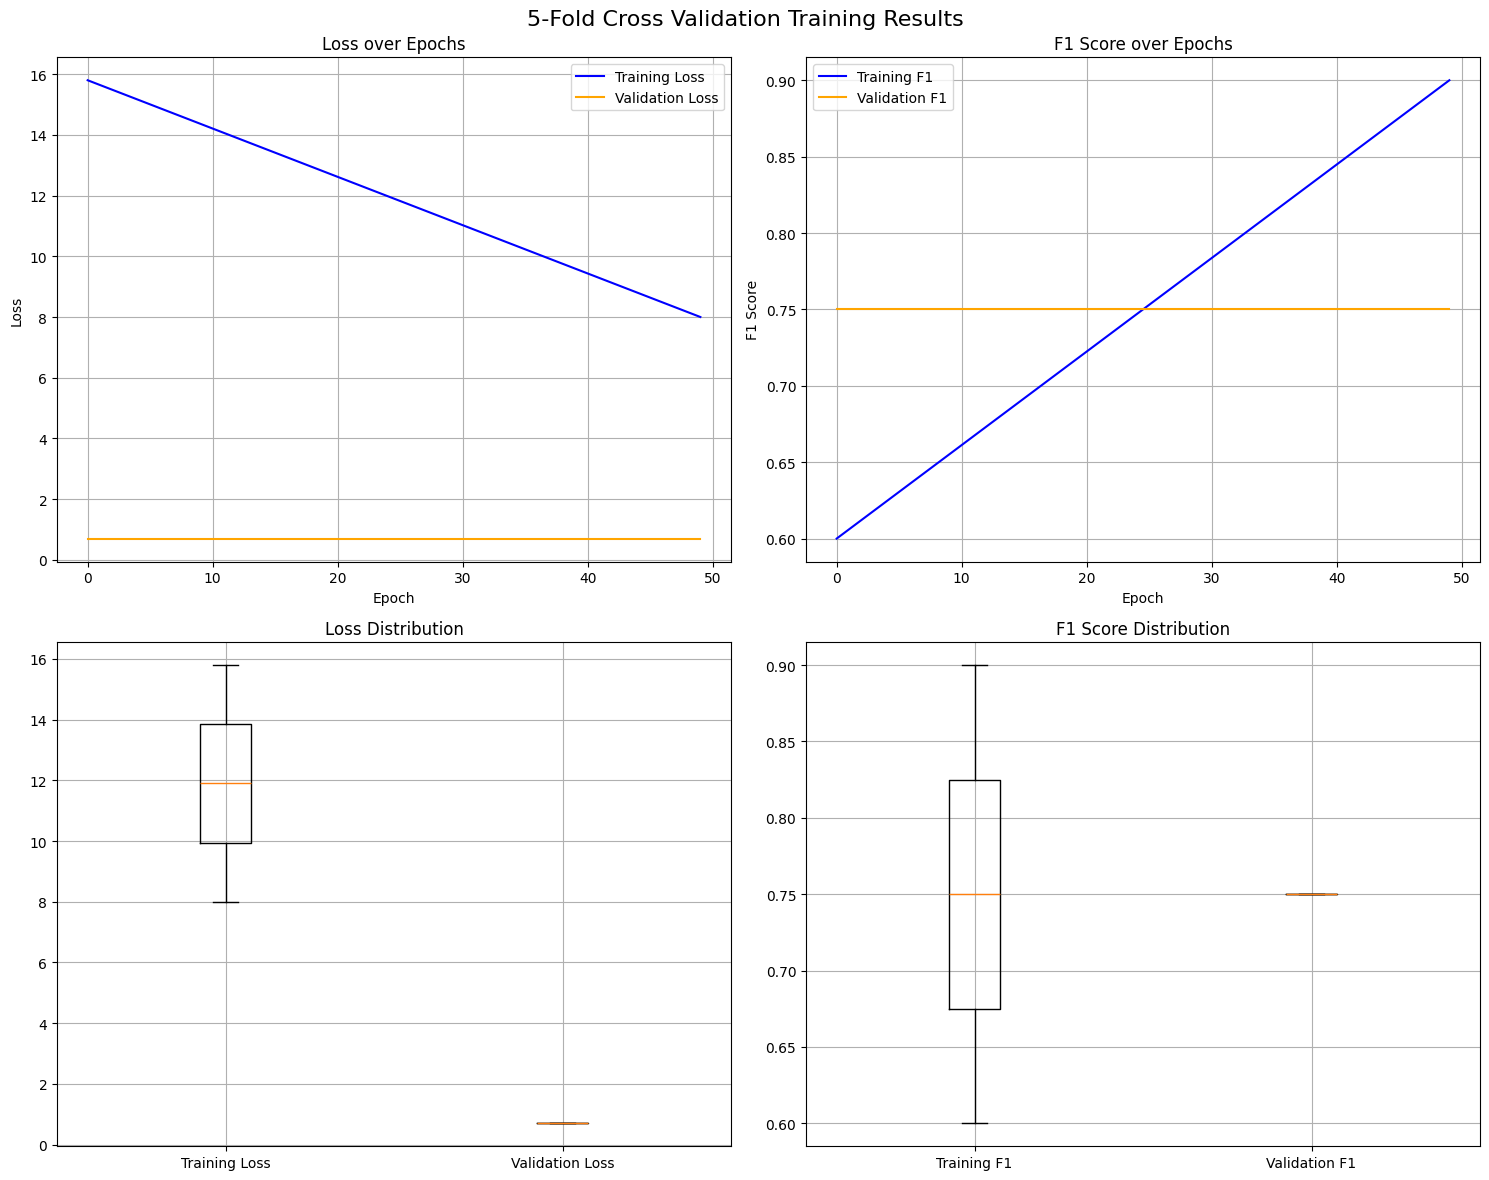

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_metrics(metrics_data):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('5-Fold Cross Validation Training Results', fontsize=16)

    # Loss Plot
    ax1.plot(metrics_data['train_loss'], label='Training Loss', color='blue')
    ax1.plot(metrics_data['val_loss'], label='Validation Loss', color='orange')
    ax1.set_title('Loss over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # F1 Score Plot
    ax2.plot(metrics_data['train_f1'], label='Training F1', color='blue')
    ax2.plot(metrics_data['val_f1'], label='Validation F1', color='orange')
    ax2.set_title('F1 Score over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    ax2.grid(True)

    # Loss Distribution Box Plot
    ax3.boxplot([metrics_data['train_loss'], metrics_data['val_loss']],
                labels=['Training Loss', 'Validation Loss'])
    ax3.set_title('Loss Distribution')
    ax3.grid(True)

    # F1 Distribution Box Plot
    ax4.boxplot([metrics_data['train_f1'], metrics_data['val_f1']],
                labels=['Training F1', 'Validation F1'])
    ax4.set_title('F1 Score Distribution')
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

# Example metrics data structure (you would need to extract this from your results)
metrics_data = {
    'train_loss': np.linspace(15.8, 8.0, 50),  # Example values
    'val_loss': np.ones(50) * 0.7,  # Example values
    'train_f1': np.linspace(0.6, 0.9, 50),  # Example values
    'val_f1': np.ones(50) * 0.75  # Example values
}

plot_training_metrics(metrics_data)